In [715]:
import sys
sys.path.insert(0, '//home/apprenant/PycharmProjects/turnover/')
# On importe les librairies dont on aura besoin pour ce tp
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import normalize
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer
from sklearn.metrics import f1_score
from sklearn.metrics import auc
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import f_regression


Quelles sont les variables de leur modèle ? Quel est leur rôle respectif ? Expliquer la construction de variable (si construite) ou le traitement (valeur aberrantes et manquantes pour variables existantes : discrétisation, polynomialisation ?, ...)
Evaluation du modèle : f_statistique, courbe roc, etc
Réponse aux questions 

In [716]:
df_train = pd.read_csv('../data/attrition_train.csv')
df_test = pd.read_csv('../data/attrition_test.csv')

In [717]:
pd.set_option('display.max_columns', None)

In [718]:
df_train.shape

(1100, 35)

F mesure : Rappel : le + important : on veut bien que toutes les personnes souhaitant partir aillent dans le programme pour éviter le turn over
        Précision : Pour limiter le nombre de personnes faux positifs, parce que le programme a un coût et qu'on peut pas se permettre de le faire passer à tout le monde
        
On aurait pu utiliser un rappel en limitant le nombre de places et donc de positif qu'il renverrait

In [719]:
df_train.sample(10)

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,EnvironmentSatisfaction,Gender,HourlyRate,JobInvolvement,JobLevel,JobRole,JobSatisfaction,MaritalStatus,MonthlyIncome,MonthlyRate,NumCompaniesWorked,Over18,OverTime,PercentSalaryHike,PerformanceRating,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
657,28,Yes,Non-Travel,1366,Research & Development,24,2,Technical Degree,1,1082,2,Male,72,2,3,Healthcare Representative,1,Single,8722,12355,1,Y,No,12,3,1,80,0,10,2,2,10,7,1,9
144,39,No,Travel_Frequently,505,Research & Development,2,4,Technical Degree,1,343,3,Female,64,3,3,Healthcare Representative,3,Single,10938,6420,0,Y,No,25,4,4,80,0,20,1,3,19,6,11,8
115,32,Yes,Travel_Frequently,1125,Research & Development,16,1,Life Sciences,1,33,2,Female,72,1,1,Research Scientist,1,Single,3919,4681,1,Y,Yes,22,4,2,80,0,10,5,3,10,2,6,7
773,28,No,Travel_Rarely,1158,Research & Development,9,3,Medical,1,377,4,Male,94,3,1,Research Scientist,4,Married,2070,2613,1,Y,No,23,4,4,80,1,5,3,2,5,2,0,4
397,49,No,Non-Travel,1002,Research & Development,18,4,Life Sciences,1,275,4,Male,92,3,2,Manufacturing Director,4,Divorced,6804,23793,1,Y,Yes,15,3,1,80,2,7,0,3,7,7,1,7
491,53,No,Travel_Rarely,661,Sales,7,2,Marketing,1,862,1,Female,78,2,3,Sales Executive,4,Married,10934,20715,7,Y,Yes,18,3,4,80,1,35,3,3,5,2,0,4
695,37,No,Travel_Rarely,482,Research & Development,3,3,Other,1,689,3,Male,36,3,3,Manufacturing Director,3,Married,9434,9606,1,Y,No,15,3,3,80,1,10,2,3,10,7,7,8
534,35,No,Travel_Rarely,776,Sales,1,4,Marketing,1,100,3,Male,32,2,2,Sales Executive,1,Single,4312,23016,0,Y,No,14,3,2,80,0,16,2,3,15,13,2,8
92,43,No,Non-Travel,343,Research & Development,9,3,Life Sciences,1,1813,1,Male,52,3,1,Research Scientist,3,Single,2438,24978,4,Y,No,13,3,3,80,0,7,2,2,3,2,1,2
914,35,No,Non-Travel,1180,Research & Development,2,2,Medical,1,1804,2,Male,90,3,2,Manufacturing Director,4,Divorced,5762,24442,2,Y,No,14,3,3,80,1,15,6,3,7,7,1,7


on droppe EmployeeCount qui vaut tout le temps 1, StandardHours qui vaut tout le temps 80, EmployeeNumber qui est un id unique, Over18 : tout le temps Y, 
Que représentent HourlyRate, DailyRate, MonthlyRate ????
Daily Rate = (Monthly Rate X 12) / Total working days in a year. (copié collé)
Hourly Rate = (Daily Rate) / Total working hours in a day (interpreté)

PercentSalaryHike : Hausse de salaire

In [729]:
df_train['HoursWorkedPerDay'] = df_train['DailyRate']/df_train['HourlyRate']
df_train['DaysWorkedPerYear'] = df_train['MonthlyRate']*12/df_train['DailyRate']
df_train['DaysWorkedPerYear2'] = df_train['MonthlyIncome']*12/df_train['DailyRate']
df_train['WorkingYearsDividedByAge'] = df_train['TotalWorkingYears']/df_train['Age']
df_train['MonthlyIncomeDividedByAge'] = df_train['MonthlyIncome']/df_train['Age']
df_train['JobLevelDividedByAge'] = df_train['JobLevel']/df_train['Age']
df_train['TotalWorkingYears*JobLevel'] = df_train['TotalWorkingYears']*df_train['JobLevel']
df_train['YearsAtCompany*JobLevel'] = df_train['YearsAtCompany']*df_train['JobLevel']
df_train['MTotalWorkingYearsByMonthlyIncome'] = df_train['TotalWorkingYears']/df_train['MonthlyIncome']
df_train['YearsAtCompanyDividedByMonthlyIncome'] = df_train['YearsAtCompany']/df_train['MonthlyIncome']
df_train['Age-TotalWorkingYears'] = df_train['Age']-df_train['TotalWorkingYears']


In [730]:
df_test['HoursWorkedPerDay'] = df_test['DailyRate']/df_test['HourlyRate']
df_test['DaysWorkedPerYear'] = df_test['MonthlyRate']*12/df_test['DailyRate']
df_test['DaysWorkedPerYear2'] = df_test['MonthlyIncome']*12/df_test['DailyRate']
df_test['WorkingYearsDividedByAge'] = df_test['TotalWorkingYears']/df_test['Age']
df_test['MonthlyIncomeDividedByAge'] = df_test['MonthlyIncome']/df_test['Age']
df_test['JobLevelDividedByAge'] = df_test['JobLevel']/df_test['Age']
df_test['TotalWorkingYears*JobLevel'] = df_test['TotalWorkingYears']*df_test['JobLevel']
df_test['YearsAtCompany*JobLevel'] = df_test['YearsAtCompany']*df_test['JobLevel']
df_test['MTotalWorkingYearsByMonthlyIncome'] = df_test['TotalWorkingYears']/df_test['MonthlyIncome']
df_test['YearsAtCompanyDividedByMonthlyIncome'] = df_test['YearsAtCompany']/df_test['MonthlyIncome']
df_test['Age-TotalWorkingYears'] = df_test['Age']-df_test['TotalWorkingYears']

In [732]:
df_train.columns

Index(['Age', 'Attrition', 'BusinessTravel', 'DailyRate', 'Department',
       'DistanceFromHome', 'Education', 'EducationField', 'EmployeeCount',
       'EmployeeNumber', 'EnvironmentSatisfaction', 'Gender', 'HourlyRate',
       'JobInvolvement', 'JobLevel', 'JobRole', 'JobSatisfaction',
       'MaritalStatus', 'MonthlyIncome', 'MonthlyRate', 'NumCompaniesWorked',
       'Over18', 'OverTime', 'PercentSalaryHike', 'PerformanceRating',
       'RelationshipSatisfaction', 'StandardHours', 'StockOptionLevel',
       'TotalWorkingYears', 'TrainingTimesLastYear', 'WorkLifeBalance',
       'YearsAtCompany', 'YearsInCurrentRole', 'YearsSinceLastPromotion',
       'YearsWithCurrManager', 'HoursWorkedPerDay', 'DaysWorkedPerYear',
       'DaysWorkedPerYear2', 'WorkingYearsDividedByAge',
       'MonthlyIncomeDividedByAge', 'JobLevelDividedByAge',
       'TotalWorkingYears*JobLevel', 'YearsAtCompany*JobLevel',
       'MTotalWorkingYearsByMonthlyIncome',
       'YearsAtCompanyDividedByMonthlyIncome'

In [734]:
df_train['Attrition'].value_counts(normalize=True)

No     0.838182
Yes    0.161818
Name: Attrition, dtype: float64

In [735]:
df_train.describe()


,Age,DailyRate,DistanceFromHome,Education,EmployeeCount,EmployeeNumber,EnvironmentSatisfaction,HourlyRate,JobInvolvement,JobLevel,JobSatisfaction,MonthlyIncome,MonthlyRate,NumCompaniesWorked,PercentSalaryHike,PerformanceRating,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager,HoursWorkedPerDay,DaysWorkedPerYear,DaysWorkedPerYear2,WorkingYearsDividedByAge,MonthlyIncomeDividedByAge,JobLevelDividedByAge,TotalWorkingYears*JobLevel,YearsAtCompany*JobLevel,MTotalWorkingYearsByMonthlyIncome,YearsAtCompanyDividedByMonthlyIncome,Age-TotalWorkingYears
count,1100.000000,1100.000000,1100.000000,1100.000000,1100.0,1100.000000,1100.000000,1100.000000,1100.000000,1100.000000,1100.000000,1100.000000,1100.000000,1100.000000,1100.000000,1100.000000,1100.000000,1100.0,1100.000000,1100.000000,1100.000000,1100.000000,1100.000000,1100.000000,1100.000000,1100.000000,1100.000000,1100.000000,1100.000000,1100.000000,1100.000000,1100.000000,1100.000000,1100.000000,1100.000000,1100.000000,1100.000000
mean,36.854545,804.234545,9.301818,2.907273,1.0,1026.404545,2.730909,66.011818,2.707273,2.064545,2.737273,6536.102727,14221.912727,2.733636,15.219091,3.155455,2.697273,80.0,0.785455,11.206364,2.780909,2.780909,7.070000,4.250000,2.186364,4.199091,13.614855,334.471756,151.228319,0.287063,172.371920,0.055582,29.926364,18.351818,0.001926,0.001258,25.648182
std,9.039229,405.583238,8.093392,1.012453,0.0,598.712521,1.083564,20.374359,0.731298,1.115862,1.107125,4729.940355,7095.123330,2.533660,3.699863,0.362502,1.084338,0.0,0.848575,7.784761,1.309377,0.706269,6.147387,3.595094,3.234650,3.584848,8.826852,368.902072,198.938669,0.154049,103.505044,0.024408,36.139919,26.126361,0.001216,0.000996,6.903787
min,18.000000,102.000000,1.000000,1.000000,1.0,4.000000,1.000000,30.000000,1.000000,1.000000,1.000000,1051.000000,2094.000000,0.000000,11.000000,3.000000,1.000000,80.0,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.206897,18.142566,10.617555,0.000000,36.033333,0.016949,0.000000,0.000000,0.000000,0.000000,18.000000
25%,30.000000,460.500000,2.000000,2.000000,1.0,494.750000,2.000000,48.000000,2.000000,1.000000,2.000000,2906.500000,8049.750000,1.000000,12.000000,3.000000,2.000000,80.0,0.000000,6.000000,2.000000,2.000000,3.000000,2.000000,0.000000,2.000000,6.888065,119.081035,46.121482,0.178571,92.715973,0.034483,7.000000,4.000000,0.001166,0.000593,20.000000
50%,36.000000,805.000000,7.000000,3.000000,1.0,1031.000000,3.000000,66.000000,3.000000,2.000000,3.000000,4938.500000,14022.500000,2.000000,14.000000,3.000000,3.000000,80.0,1.000000,9.000000,3.000000,3.000000,5.000000,3.000000,1.000000,3.000000,12.076149,207.753737,86.479536,0.263158,141.839394,0.052632,18.000000,10.000000,0.001645,0.001047,24.000000
75%,42.250000,1162.000000,14.000000,4.000000,1.0,1543.250000,4.000000,84.000000,3.000000,3.000000,4.000000,8516.000000,20344.500000,4.000000,18.000000,3.000000,4.000000,80.0,1.000000,15.000000,3.000000,3.000000,9.000000,7.000000,3.000000,7.000000,18.151339,406.850927,174.363729,0.400000,228.222876,0.071429,34.000000,20.000000,0.002379,0.001663,30.000000
max,60.000000,1498.000000,29.000000,5.000000,1.0,2065.000000,4.000000,100.000000,4.000000,5.000000,4.000000,19999.000000,26997.000000,9.000000,25.000000,4.000000,4.000000,80.0,3.000000,38.000000,6.000000,4.000000,37.000000,18.000000,15.000000,17.000000,49.333333,3071.423077,2220.685714,0.672727,556.000000,0.137931,185.000000,180.000000,0.009995,0.009376,56.000000


In [736]:
print("Nombre de lignes dupliquées")
print(df_train.duplicated().value_counts())
print("\n" + "Nombre de valeurs manquantes")
print(df_train.isnull().sum())

Nombre de lignes dupliquées
False    1100
dtype: int64

Nombre de valeurs manquantes
Age                                     0
Attrition                               0
BusinessTravel                          0
DailyRate                               0
Department                              0
DistanceFromHome                        0
Education                               0
EducationField                          0
EmployeeCount                           0
EmployeeNumber                          0
EnvironmentSatisfaction                 0
Gender                                  0
HourlyRate                              0
JobInvolvement                          0
JobLevel                                0
JobRole                                 0
JobSatisfaction                         0
MaritalStatus                           0
MonthlyIncome                           0
MonthlyRate                             0
NumCompaniesWorked                      0
Over18                           

In [738]:
df_train = df_train[df_train.columns.difference(['EmployeeNumber', 'EmployeeCount', 'StandardHours', 'Over18'])]
df_test = df_test[df_test.columns.difference(['EmployeeNumber', 'EmployeeCount', 'StandardHours', 'Over18', 'index1'])]

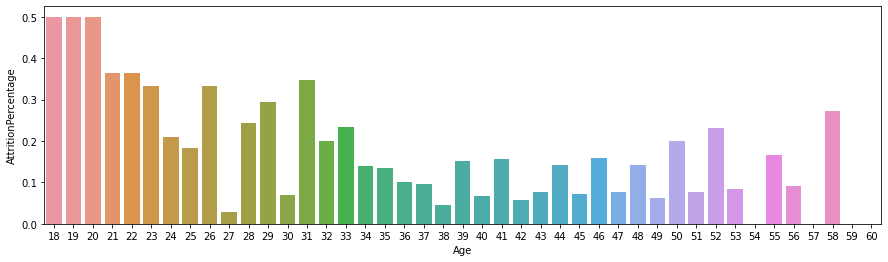

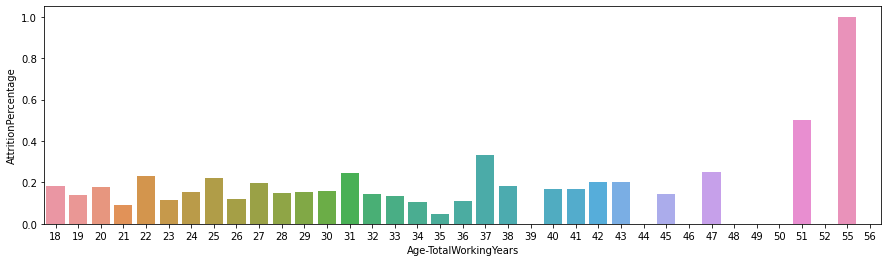

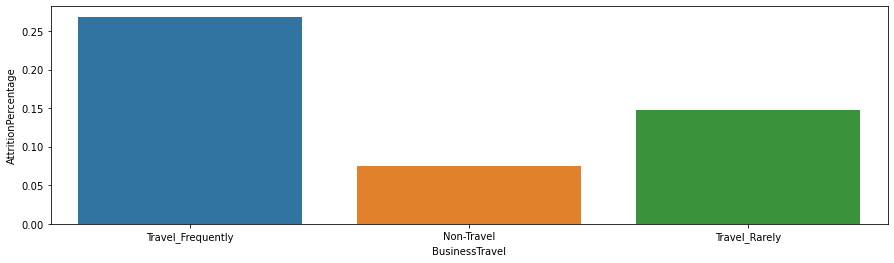

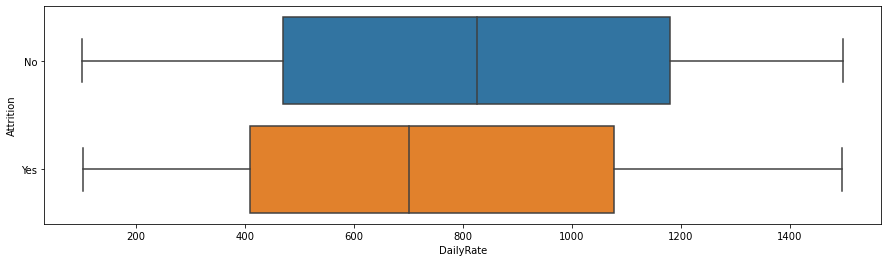

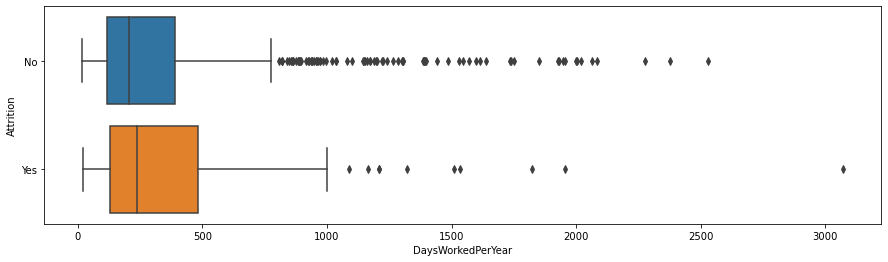

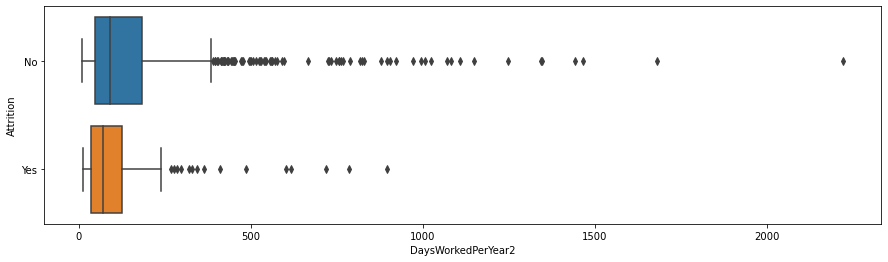

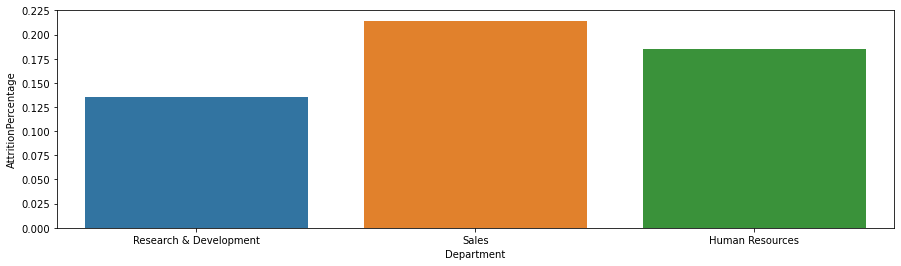

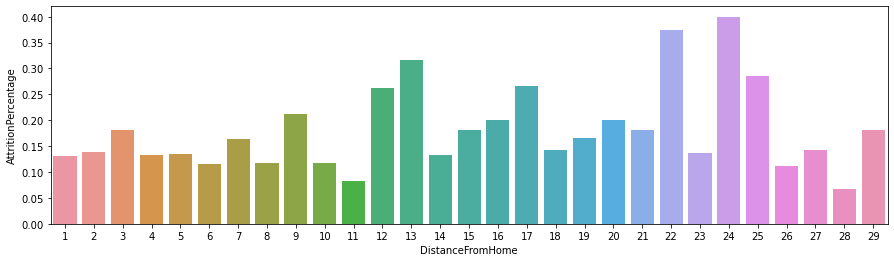

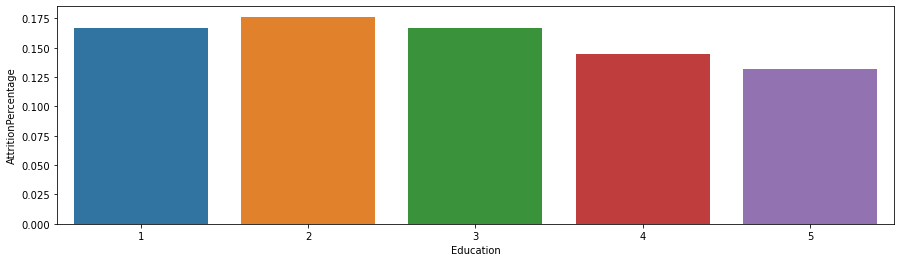

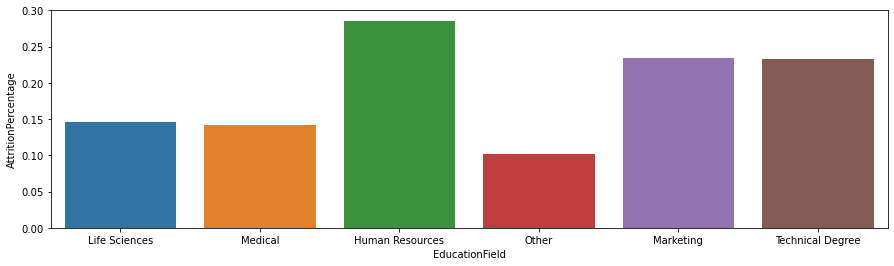

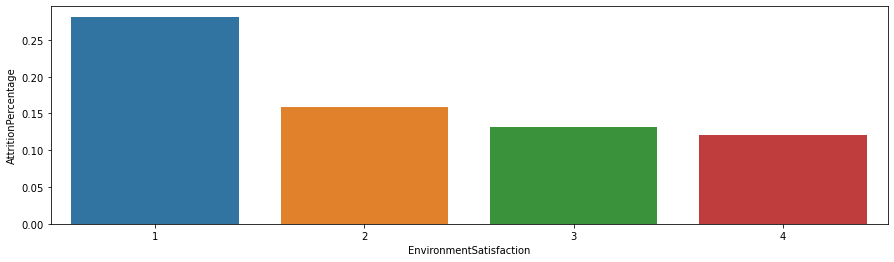

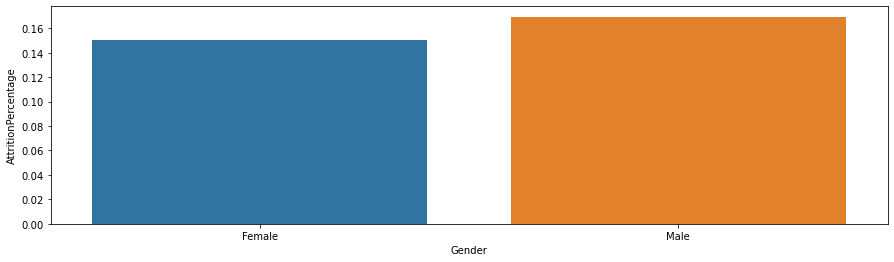

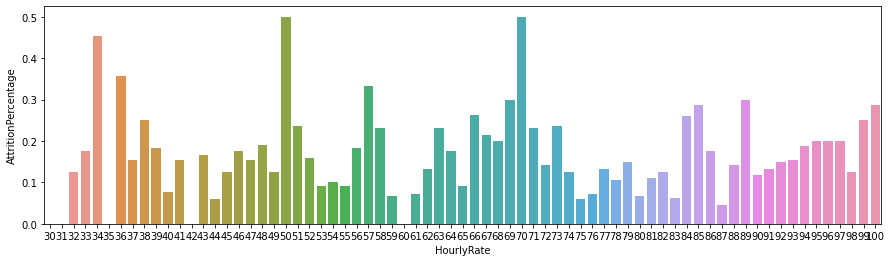

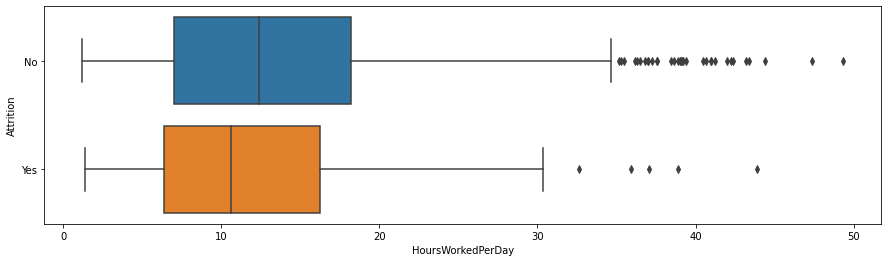

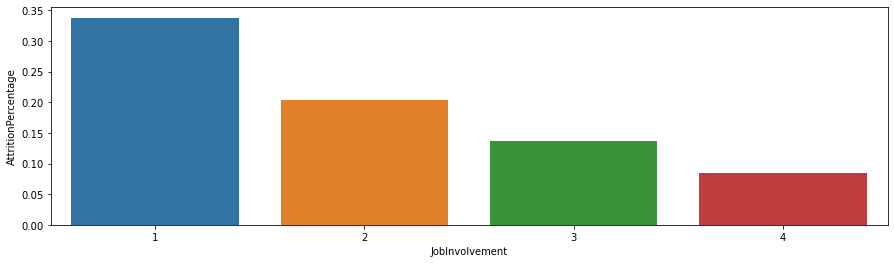

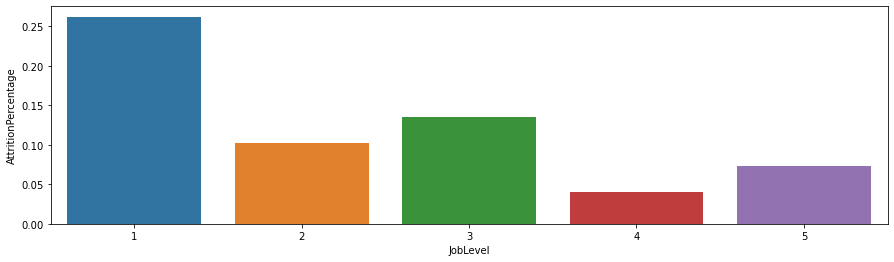

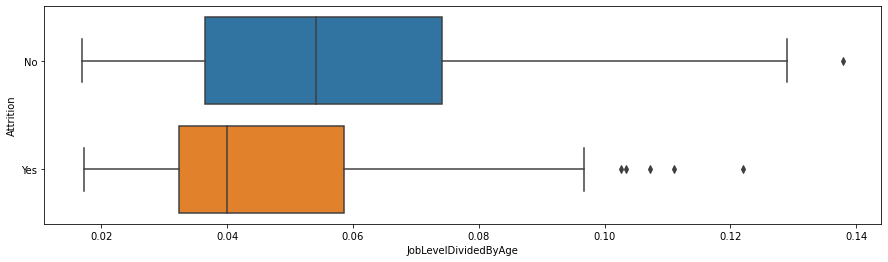

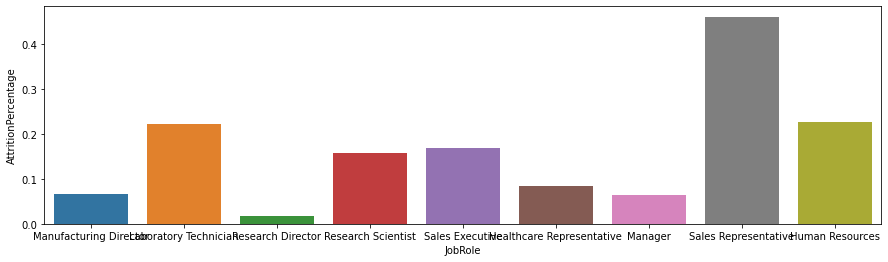

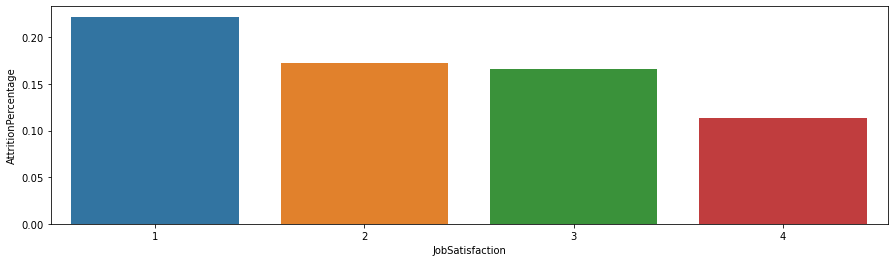

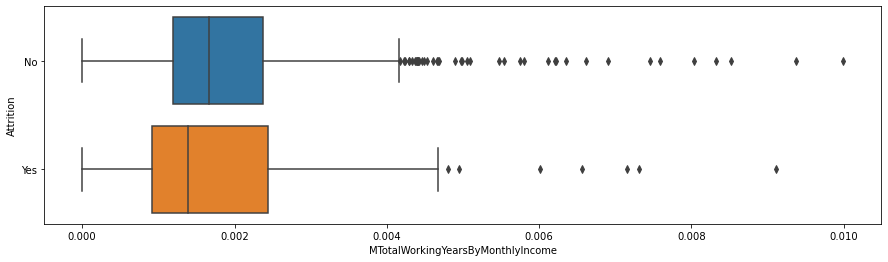

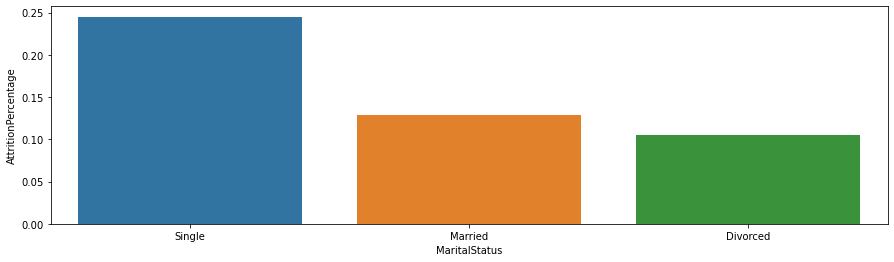

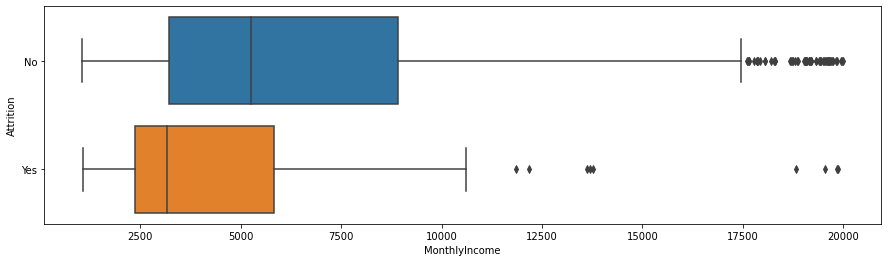

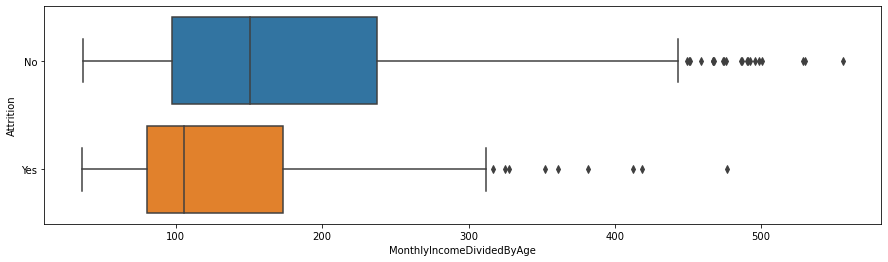

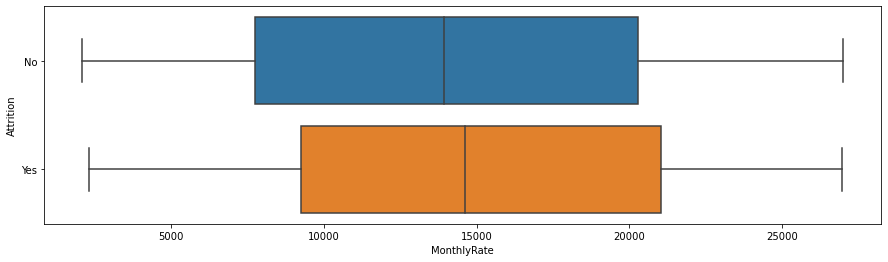

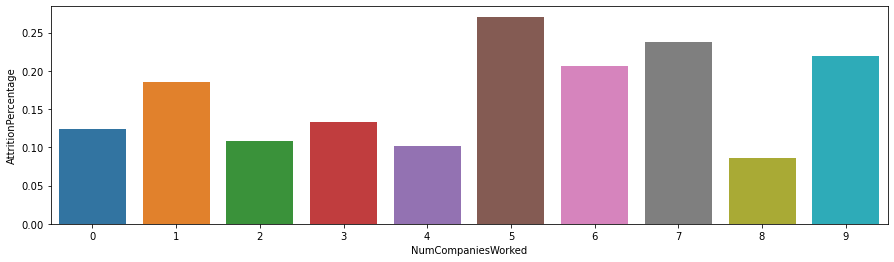

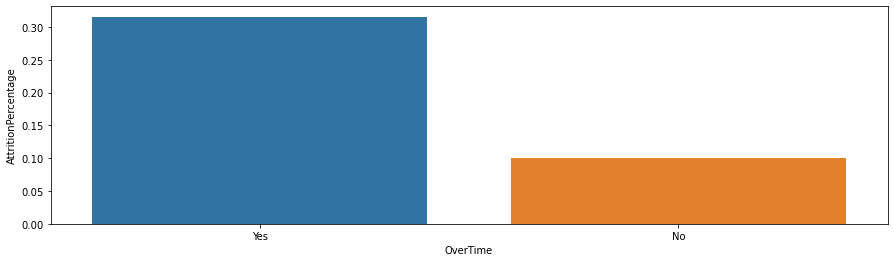

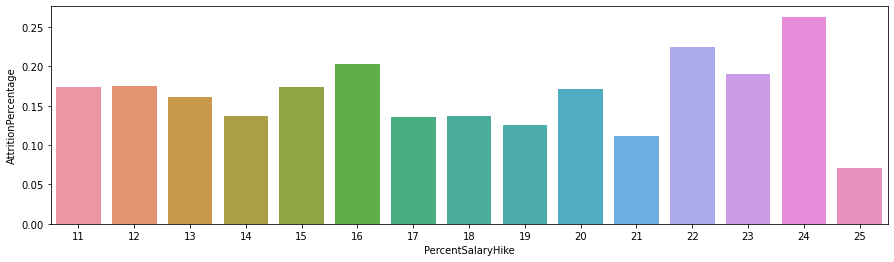

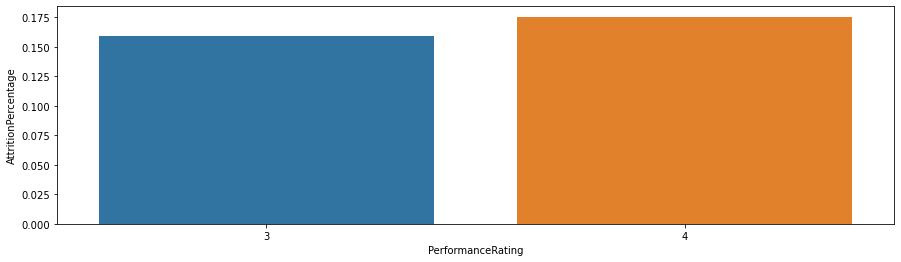

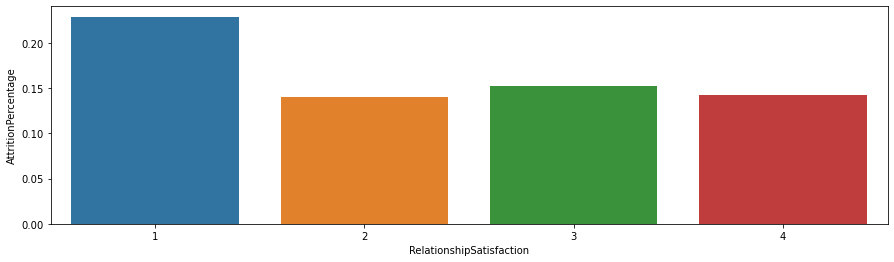

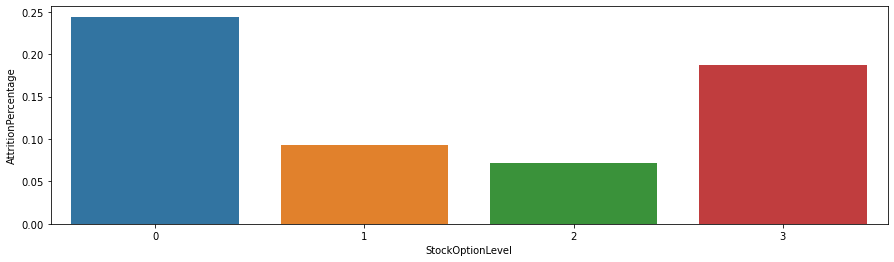

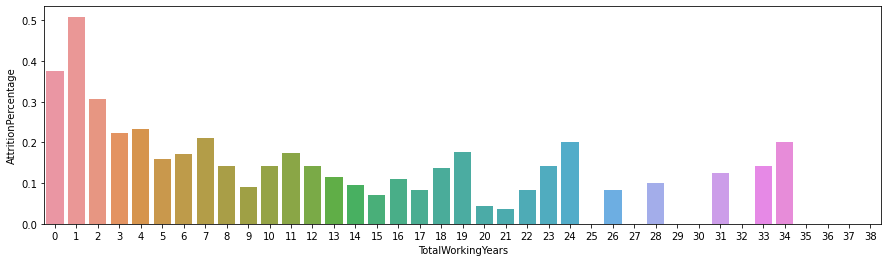

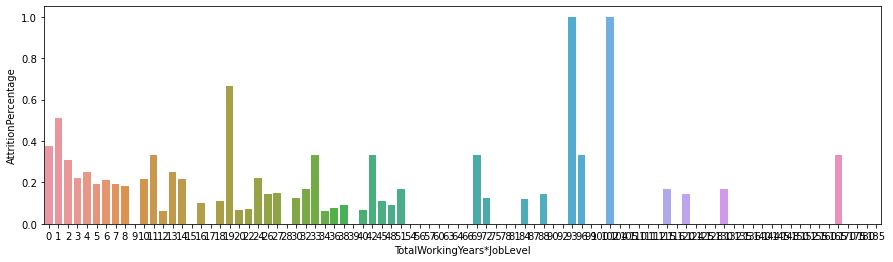

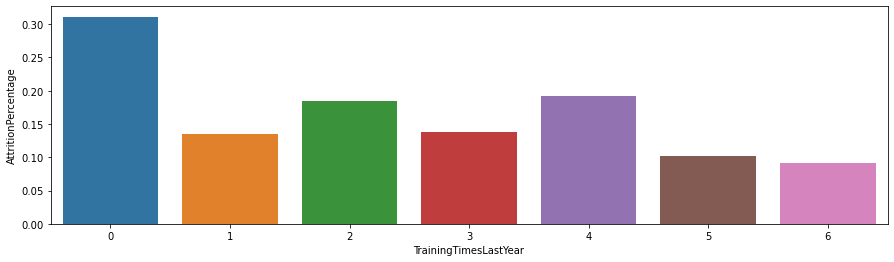

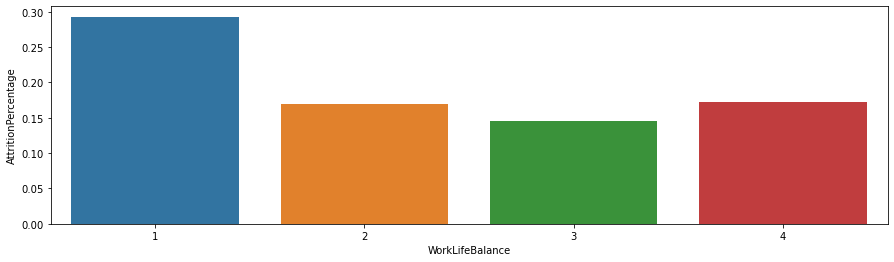

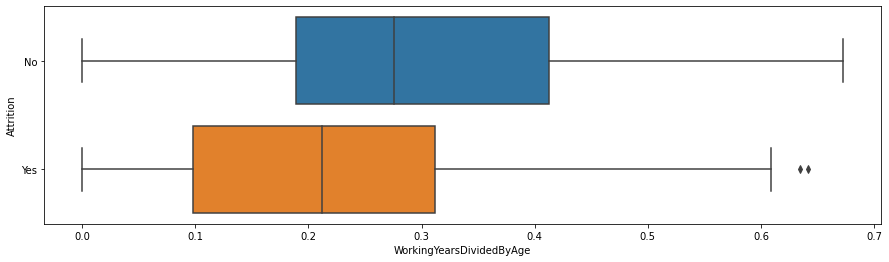

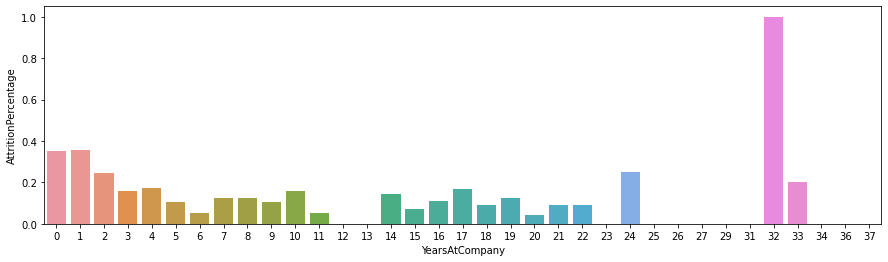

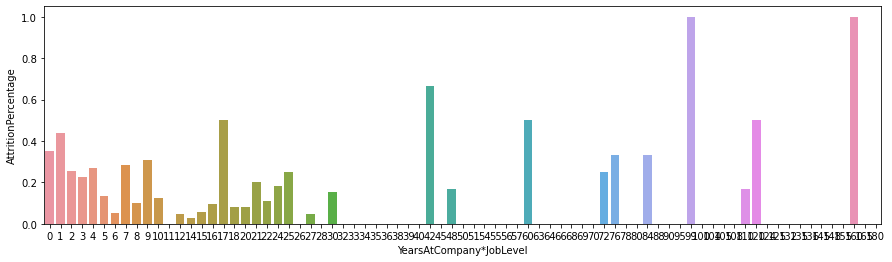

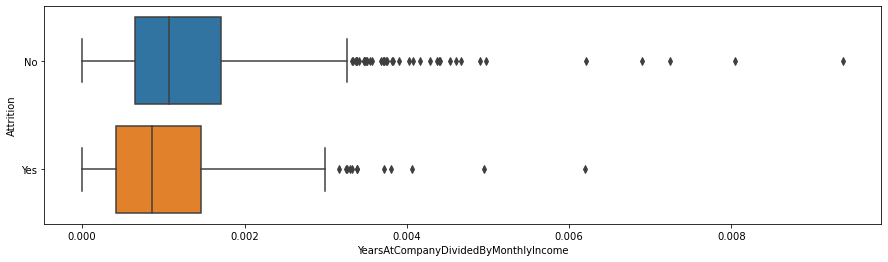

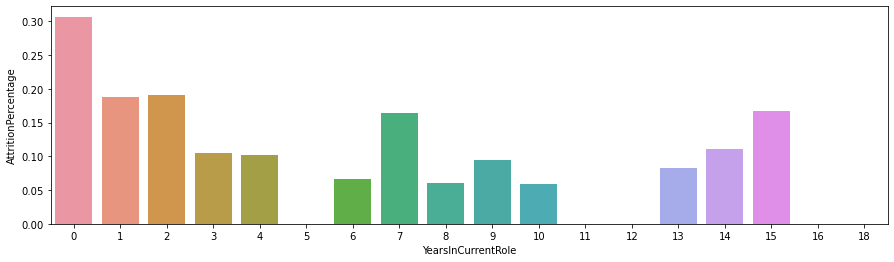

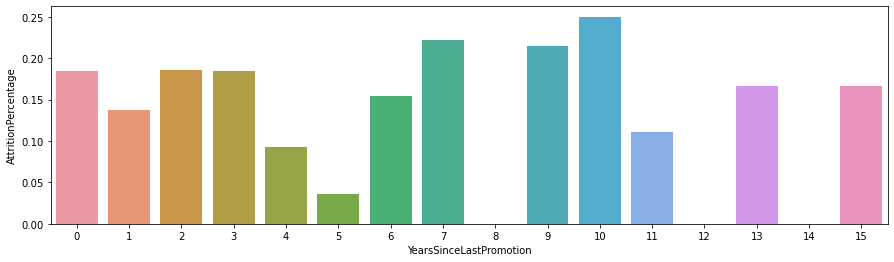

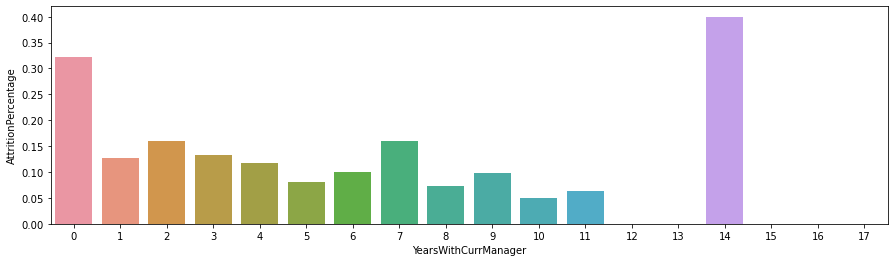

In [742]:
for col in df_train.columns.difference(['Attrition']):
    plt.figure(figsize=(15,4))
    x=list(df_train[col].unique())
    if len(x) > 100:
        ax = sns.boxplot(x=col, y="Attrition", data=df_train)
    else:
        y=[]
        for val in x:
            try:
                y.append(df_train[df_train[col] == val]['Attrition'].value_counts(normalize=True)['Yes'])
            except:
                y.append(1-df_train[df_train[col] == val]['Attrition'].value_counts(normalize=True)['No'])
        sns.barplot(x=x, y=y)
        plt.xlabel(col)
        plt.ylabel('AttritionPercentage')
    # Display the plot
    plt.show()
    # Close the current plot to stop retaining memory
    plt.close()

In [743]:
cols_corr = ['YearsWithCurrManager', 'YearsInCurrentRole', 'WorkLifeBalance', 'TrainingTimesLastYear', 'RelationshipSatisfaction', 'PerformanceRating', 'OverTime', 'NumCompaniesWorked', 'MonthlyRate', 'MonthlyIncome', 'MaritalStatus', 'JobSatisfaction', 'JobRole', 'JobLevel', 'JobInvolvement', 'Gender', 'EnvironmentSatisfaction', 'EducationField', 'Education', 'Department', 'DailyRate', 'BusinessTravel', 'Age']

In [744]:
catg = df_train.select_dtypes(include=[object]).columns.difference(['Attrition'])

print(catg)

Index(['BusinessTravel', 'Department', 'EducationField', 'Gender', 'JobRole',
       'MaritalStatus', 'OverTime'],
      dtype='object')


In [745]:
le = LabelEncoder()

encoded_catg = pd.DataFrame()
for col in catg:
    if len(df_train[col].unique()) <= 2:
        le.fit(df_train[col])
        df_train[col] = le.transform(df_train[col])
    else:
        encoded_catg = pd.concat([encoded_catg, pd.get_dummies(df_train[col], prefix=col)], axis=1)

In [746]:
encoded_catg.head()

,BusinessTravel_Non-Travel,BusinessTravel_Travel_Frequently,BusinessTravel_Travel_Rarely,Department_Human Resources,Department_Research & Development,Department_Sales,EducationField_Human Resources,EducationField_Life Sciences,EducationField_Marketing,EducationField_Medical,EducationField_Other,EducationField_Technical Degree,JobRole_Healthcare Representative,JobRole_Human Resources,JobRole_Laboratory Technician,JobRole_Manager,JobRole_Manufacturing Director,JobRole_Research Director,JobRole_Research Scientist,JobRole_Sales Executive,JobRole_Sales Representative,MaritalStatus_Divorced,MaritalStatus_Married,MaritalStatus_Single
0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1
1,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0
2,1,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0
3,0,0,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0
4,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0


In [748]:
catg = df_test.select_dtypes(include=[object])
encoded_catg_test = pd.DataFrame()
for col in catg:
    if len(df_test[col].unique()) <= 2:
        le.fit(df_test[col])
        df_test[col] = le.transform(df_test[col])
    else:
        encoded_catg_test = pd.concat([encoded_catg_test, pd.get_dummies(df_test[col], prefix=col)], axis=1)  
Xfinal = pd.concat([df_test.select_dtypes(include=['float64', 'int64']), encoded_catg_test], axis=1)

In [749]:
result={}
result['Metric'] = ('F1_score', 'Auc')

# Logistic Regression

In [750]:
X= pd.concat([df_train.select_dtypes(include=['float64', 'int64']), encoded_catg], axis=1)
y=df_train['Attrition']

In [751]:
from sklearn.feature_selection import RFECV
estimator = LogisticRegression(max_iter=10000, solver="liblinear", penalty='l1')
selector = RFECV(estimator, step=1, cv=5)
Xnorm = normalize(X, norm='max', axis=0)
selector = selector.fit(Xnorm, y)

In [752]:
selector.support_

array([ True, False, False, False, False,  True, False,  True, False,
       False, False,  True, False, False,  True, False,  True, False,
       False,  True,  True, False, False,  True,  True, False, False,
        True,  True,  True, False, False, False,  True,  True,  True,
       False,  True,  True, False, False,  True,  True, False, False,
       False, False, False, False,  True,  True, False, False, False,
       False, False,  True, False, False,  True])

In [753]:
selector.ranking_

array([ 1, 22,  8, 20, 19,  1, 12,  1,  4,  3, 21,  1, 32, 31,  1, 17,  1,
       24, 11,  1,  1, 35, 37,  1,  1, 23, 25,  1,  1,  1, 36, 34, 30,  1,
        1,  1, 15,  1,  1, 26, 27,  1,  1, 28,  6, 14,  7,  2, 16,  1,  1,
       33,  9,  5, 29, 13,  1, 18, 10,  1])

In [754]:
X.columns

Index(['Age', 'Age-TotalWorkingYears', 'DailyRate', 'DaysWorkedPerYear',
       'DaysWorkedPerYear2', 'DistanceFromHome', 'Education',
       'EnvironmentSatisfaction', 'Gender', 'HourlyRate', 'HoursWorkedPerDay',
       'JobInvolvement', 'JobLevel', 'JobLevelDividedByAge', 'JobSatisfaction',
       'MTotalWorkingYearsByMonthlyIncome', 'MonthlyIncome',
       'MonthlyIncomeDividedByAge', 'MonthlyRate', 'NumCompaniesWorked',
       'OverTime', 'PercentSalaryHike', 'PerformanceRating',
       'RelationshipSatisfaction', 'StockOptionLevel', 'TotalWorkingYears',
       'TotalWorkingYears*JobLevel', 'TrainingTimesLastYear',
       'WorkLifeBalance', 'WorkingYearsDividedByAge', 'YearsAtCompany',
       'YearsAtCompany*JobLevel', 'YearsAtCompanyDividedByMonthlyIncome',
       'YearsInCurrentRole', 'YearsSinceLastPromotion', 'YearsWithCurrManager',
       'BusinessTravel_Non-Travel', 'BusinessTravel_Travel_Frequently',
       'BusinessTravel_Travel_Rarely', 'Department_Human Resources',
      

In [755]:
RFECV_selected = X.columns[selector.support_]

In [756]:
RFECV_selected

Index(['Age', 'DistanceFromHome', 'EnvironmentSatisfaction', 'JobInvolvement',
       'JobSatisfaction', 'MonthlyIncome', 'NumCompaniesWorked', 'OverTime',
       'RelationshipSatisfaction', 'StockOptionLevel', 'TrainingTimesLastYear',
       'WorkLifeBalance', 'WorkingYearsDividedByAge', 'YearsInCurrentRole',
       'YearsSinceLastPromotion', 'YearsWithCurrManager',
       'BusinessTravel_Travel_Frequently', 'BusinessTravel_Travel_Rarely',
       'Department_Sales', 'EducationField_Human Resources',
       'JobRole_Human Resources', 'JobRole_Laboratory Technician',
       'JobRole_Sales Representative', 'MaritalStatus_Single'],
      dtype='object')

In [767]:
X=X[RFECV_selected]
Xfinal=Xfinal[RFECV_selected]

In [770]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
xtrain, xtest, ytrain, ytest = train_test_split(X, y, train_size=0.8, random_state=1)

In [771]:
model = LogisticRegression(max_iter=10000, solver="liblinear", penalty='l1')

In [772]:
clf = model.fit(xtrain, ytrain)

In [773]:
f1_scorer = make_scorer(f1_score, pos_label="Yes")

In [774]:
print(np.mean(cross_val_score(clf, Xnorm, y, cv=5, scoring=f1_scorer)))

0.5314510512550383


In [775]:

ytestpred = clf.predict(xtest)

In [776]:
ytest.value_counts()

No     186
Yes     34
Name: Attrition, dtype: int64

In [777]:
ytestpred

array(['No', 'No', 'No', 'No', 'Yes', 'No', 'No', 'Yes', 'No', 'No', 'No',
       'Yes', 'No', 'Yes', 'No', 'No', 'No', 'No', 'No', 'No', 'No', 'No',
       'No', 'No', 'No', 'No', 'No', 'No', 'No', 'No', 'No', 'No', 'No',
       'No', 'No', 'No', 'No', 'No', 'No', 'No', 'No', 'No', 'No', 'No',
       'No', 'No', 'No', 'No', 'No', 'No', 'No', 'No', 'No', 'No', 'No',
       'No', 'No', 'No', 'No', 'No', 'No', 'No', 'No', 'No', 'No', 'No',
       'No', 'No', 'No', 'No', 'No', 'No', 'No', 'No', 'No', 'No', 'No',
       'Yes', 'Yes', 'No', 'No', 'No', 'No', 'No', 'No', 'No', 'Yes',
       'No', 'No', 'Yes', 'No', 'No', 'No', 'No', 'No', 'No', 'No', 'Yes',
       'No', 'No', 'No', 'No', 'No', 'Yes', 'No', 'No', 'No', 'No', 'No',
       'No', 'No', 'No', 'No', 'Yes', 'No', 'No', 'No', 'Yes', 'No',
       'Yes', 'No', 'No', 'No', 'No', 'No', 'No', 'Yes', 'No', 'No', 'No',
       'No', 'No', 'No', 'No', 'No', 'No', 'No', 'No', 'No', 'No', 'No',
       'No', 'No', 'No', 'No', 'No', 'No', 'No', 

In [778]:
clf.predict_proba(xtest)[:,1]

array([0.09362104, 0.02969368, 0.31422045, 0.42608986, 0.71461886,
       0.06241363, 0.27138647, 0.6596679 , 0.06403207, 0.01121256,
       0.02754731, 0.55274622, 0.24741001, 0.54965607, 0.00430393,
       0.25459823, 0.2330091 , 0.02447097, 0.04129647, 0.00709116,
       0.0453947 , 0.04344687, 0.05772713, 0.01580983, 0.0599422 ,
       0.06844233, 0.23707049, 0.01012993, 0.00990765, 0.02842232,
       0.13737463, 0.32606472, 0.026437  , 0.16595359, 0.26914624,
       0.0988003 , 0.03294644, 0.0135227 , 0.01828042, 0.04597651,
       0.04008097, 0.02273983, 0.10823693, 0.08425379, 0.05453187,
       0.06632723, 0.09545932, 0.10196571, 0.01027774, 0.05941147,
       0.0089142 , 0.00694959, 0.45985462, 0.01247745, 0.07069923,
       0.03115092, 0.119765  , 0.00260401, 0.04334563, 0.01688935,
       0.00612463, 0.06793783, 0.01479169, 0.39059047, 0.01100624,
       0.46001383, 0.03219486, 0.26068783, 0.12973643, 0.02011548,
       0.00816004, 0.02166912, 0.04516861, 0.13598899, 0.11492

In [779]:
f1_score(ytest, ytestpred, pos_label='Yes')

0.6909090909090908

In [781]:
roc_auc_score(ytest, clf.predict_proba(xtest)[:,1])

0.9440227703984819

In [782]:
np.mean(cross_val_score(clf, X, y, cv=5, scoring='roc_auc'))

0.854107348031261

In [783]:
result['Logistic'] = (np.mean(cross_val_score(clf, X, y, cv=5, scoring=f1_scorer)), np.mean(cross_val_score(clf, X, y, cv=5, scoring='roc_auc')))

f1_score : 0.47058823529411764, params : max_iter=10000, solver="liblinear"

f1_score : 0.48275862068965514, params : max_iter=10000, solver="liblinear", penalty='l1'

In [784]:
ypred = clf.predict(X)

In [785]:
np.unique(ypred)

array(['No', 'Yes'], dtype=object)

In [786]:
yfinal = clf.predict(Xfinal)

In [787]:
unique_elements, counts_elements = np.unique(yfinal, return_counts=True)

In [788]:
unique_elements

array(['No', 'Yes'], dtype=object)

In [789]:
counts_elements

array([349,  21])

In [790]:
df_coef = pd.DataFrame({'colonne': X.columns, 'coeffs':clf.coef_[0], 'coeffs_abs': abs(clf.coef_[0])})
display(df_coef.sort_values(by='coeffs_abs', ascending=False))


,colonne,coeffs,coeffs_abs
7,OverTime,1.760315,1.760315
16,BusinessTravel_Travel_Frequently,1.466551,1.466551
12,WorkingYearsDividedByAge,-1.040143,1.040143
20,JobRole_Human Resources,0.965763,0.965763
22,JobRole_Sales Representative,0.870830,0.870830
18,Department_Sales,0.828956,0.828956
21,JobRole_Laboratory Technician,0.803798,0.803798
17,BusinessTravel_Travel_Rarely,0.803793,0.803793
23,MaritalStatus_Single,0.665313,0.665313
3,JobInvolvement,-0.545527,0.545527


In [791]:
import eli5
from eli5.sklearn import PermutationImportance

perm = PermutationImportance(clf).fit(xtest, ytest)
eli5.show_weights(perm, feature_names = X.columns.tolist())

Weight,Feature
0.0364 ± 0.0230,OverTime
0.0327 ± 0.0156,BusinessTravel_Travel_Frequently
0.0200 ± 0.0045,JobInvolvement
0.0182 ± 0.0141,RelationshipSatisfaction
0.0182 ± 0.0115,EnvironmentSatisfaction
0.0173 ± 0.0240,YearsSinceLastPromotion
0.0145 ± 0.0145,JobSatisfaction
0.0118 ± 0.0093,MonthlyIncome
0.0109 ± 0.0148,DistanceFromHome
0.0100 ± 0.0106,YearsInCurrentRole


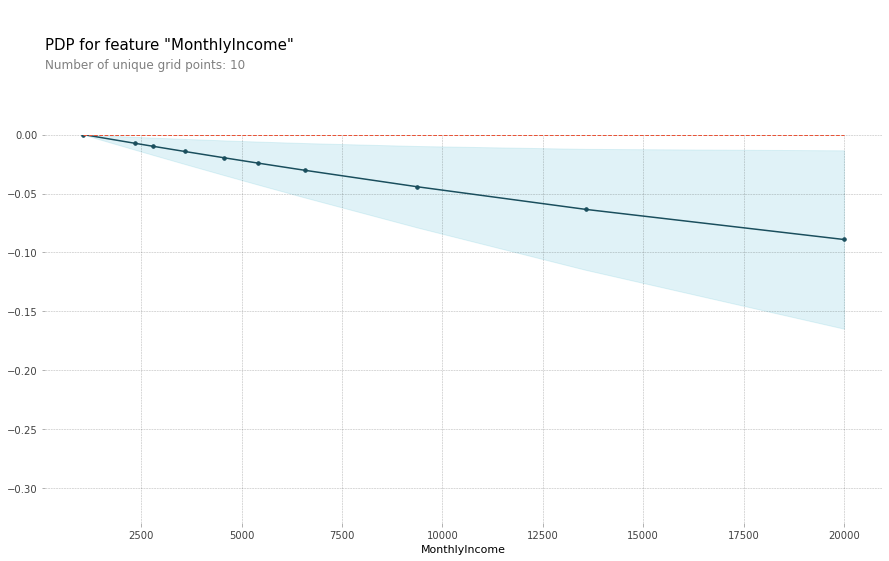

In [792]:
from pdpbox import pdp, get_dataset, info_plots

# Create the data that we will plot
pdp_attrition = pdp.pdp_isolate(model=clf, dataset=X, model_features=X.columns.tolist(), feature='MonthlyIncome')

# plot it
pdp.pdp_plot(pdp_attrition, 'MonthlyIncome')
plt.show()

In [793]:
import shap  # package used to calculate Shap values


row_to_show = 80
data_for_prediction = xtest.iloc[row_to_show]  # use 1 row of data here. Could use multiple rows if desired
data_for_prediction_array = data_for_prediction.values.reshape(1, -1)


print(ytest.iloc[row_to_show])


# Create object that can calculate shap values
explainer = shap.LinearExplainer(clf, xtrain)

# Calculate Shap values
shap_values = explainer.shap_values(xtest)


shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[row_to_show], data_for_prediction)



No


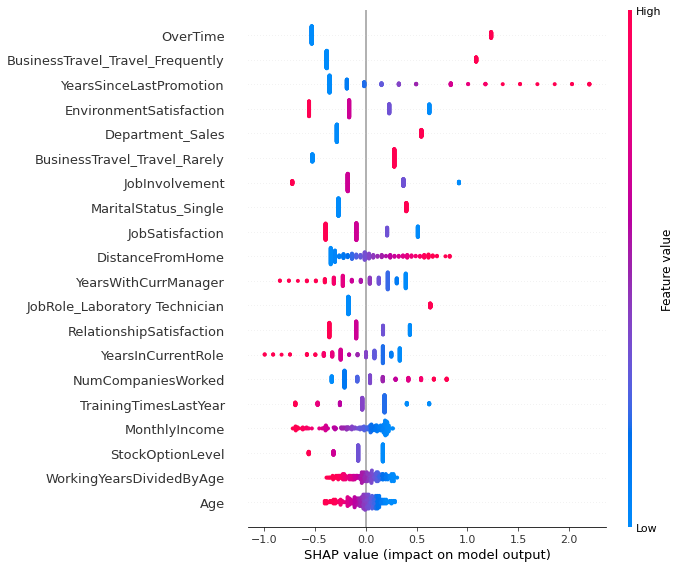

In [794]:
shap.summary_plot(shap_values, xtest)

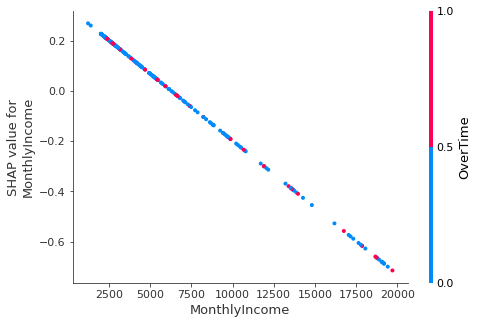

In [795]:
shap.dependence_plot('MonthlyIncome', shap_values, xtest, interaction_index="OverTime")

In [796]:
ind=80
explainer = shap.LinearExplainer(model,xtrain)
shap_values = explainer.shap_values(xtest.iloc[ind])

shap.initjs()
shap.force_plot(explainer.expected_value, shap_values, xtest.iloc[ind])



In [797]:
result

{'Metric': ('F1_score', 'Auc'),
 'Logistic': (0.5795509023281444, 0.853954297465167)}

{'Metric': ('F1_score', 'Auc'),
 'Logistic': (0.5406599326599326, 0.8320189179863092)} : K=25, f_classif
 result

{'Metric': ('F1_score', 'Auc'),
 'Logistic': (0.48306114898789704, 0.8303836196444893)}: K=15, f_classif